# Unsupervised Learning

In contrast to supervised learning, we can still try to learn something about data sets by using _unsupervised_ methods.

Because these are unsupervised, we don't have the benefit of training data. As such, we can't minimize a cost function over the training process.

However, there are some things that we can do to expose patterns in the data.


## Types of Unsupervised Learning

There are a number of families of algorithms for unsupervised learning.  Some of them we've already seen:

* Manifold Learning (like dimenionality reduction)
* Gaussian Mixture Models
* Clustering
* Biclustering
* Signal decomposition (including PCA, LDA, and Non-negative Matrix Factorization)
* Covariance Estimation
* Novelty and Outlier Detection
* Density Estimation
* Some Neural Network Models (embeddings, RBMs, autoencoders)

For this course, we'll focus our attention on *clustering*.

## Clustering

The goal of clustering algorithms is to separate out samples based on measurable characteristics of the data as they exist.  For example, this could be taking a set of samples like:

In [1]:
from sklearn.datasets.samples_generator import make_blobs
import pandas as pd
random_state = 0
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=.6,
                            random_state=random_state)
df = pd.DataFrame(X)
df['labels_true'] = labels_true
df.columns = ['x', 'y', 'label']
df.head()

,x,y,label
0,0.760331,1.222034,0
1,-1.232123,-1.306176,1
2,0.517954,0.586270,0
3,0.176174,-1.640645,2
4,1.738174,1.721428,0


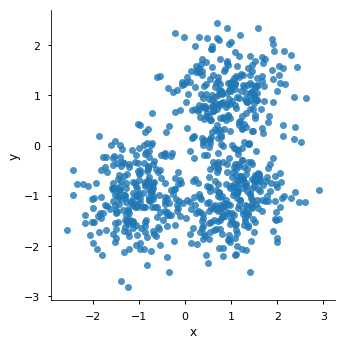

In [2]:
%matplotlib inline
import seaborn as sns
sns.set_context('notebook', font_scale=1.1)
sns.lmplot('x', 'y', data=df, fit_reg=False)

As you can see above, there are three "visually distinct" groups (or "clusters") of data.

While these _may_ not correspond to classes in the sense of classification, it's still a _good_ analysis to be able to separate a population into segments and explain how they differ.

Clustering helps us perform this segmentation.

##  $K$-means Clustering

One of the simplest clustering algorithms is $K$-means clustering.

From the scikit learn docs:
> The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. 

The algorithm is initialized with a number of clusters ($k$) and splits the data points into disjoint groups each described by the mean of the samples in the cluster.  These means are referred to as _centroids_ and are not real points in the dataset, but represent something like the "center of mass" of the points in that cluster.

The algorithm iteratively tries to choose centroids that minimize a quantity known of as the _interia_ as the within-cluster sum of squares: $\sum{min(||x_j-\mu||^2)}$

This measure of inertia can be thought of as a measure of "coherence" of the clusters.  That is, optimizing for clusters that are tighter and rounder.

### Aside:  How does inertia function?

When we look at the inertia function $\sum{min(||x_j-\mu||^2)}$, what does it look _a lot_ like?

This is a lot like a _cost_ function from supervised learning.  In a sense, the designers of k-means have "hacked" their situation to come up with a way to measure performance without having supervised training data.

Most cases of unsupervised learning still have a cost function, it's simply not based on labelled samples.

### Drawbacks to $k$-means

There are several drawbacks to k-means clustering:

* Inertia assumes that clusters will be convex and non-isotropic
* Inertia is not a normalized metric: There is no max, but we know lower-is-better and zero is best. But in very high-dimensional spaces, Euclidean (straight line) distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”).

## Examples of $k$-means clustering

Below are examples of running `KMeans` on the sample dataset from above.  We'll first examine when it goes well, and then when it goes...  less well.

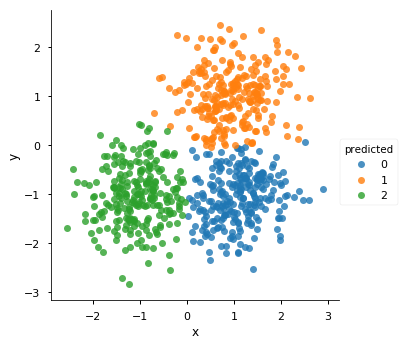

In [3]:
from sklearn.cluster import KMeans

y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(df[['x', 'y']])
df['predicted'] = y_pred
sns.lmplot('x', 'y', data=df, hue='predicted', fit_reg=False)


Now lets see what happens if we pick the wrong number of clusters.

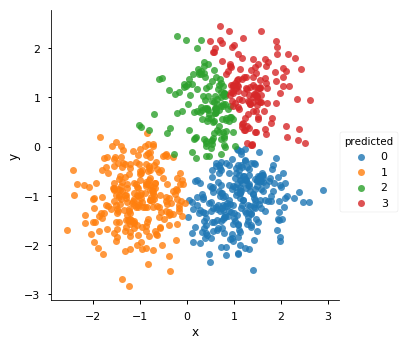

In [4]:
y_pred = KMeans(n_clusters=4, random_state=random_state).fit_predict(df[['x', 'y']])
df['predicted'] = y_pred
sns.lmplot('x', 'y', data=df, hue='predicted', fit_reg=False)

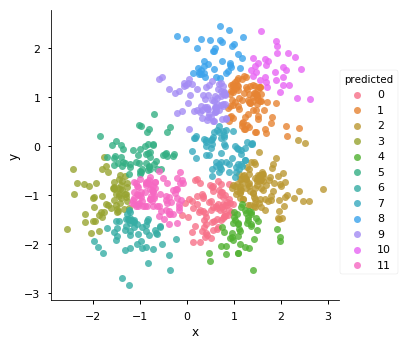

In [5]:
y_pred = KMeans(n_clusters=12, random_state=random_state).fit_predict(df[['x', 'y']])
df['predicted'] = y_pred
sns.lmplot('x', 'y', data=df, hue='predicted', fit_reg=False)

## Other Examples of $k$-means Failures

Here are some examples of ways that the core assumptions of $k$-means (number of blobs, isotropically distributed data, equal variance, and even sizes) can fail:

![sphx_glr_plot_kmeans_assumptions_001.png](sphx_glr_plot_kmeans_assumptions_001.png)

# An Overall Comparison of Many Clustering Techniques

The following code and chart are taken from the sklearn documentation on clustering.

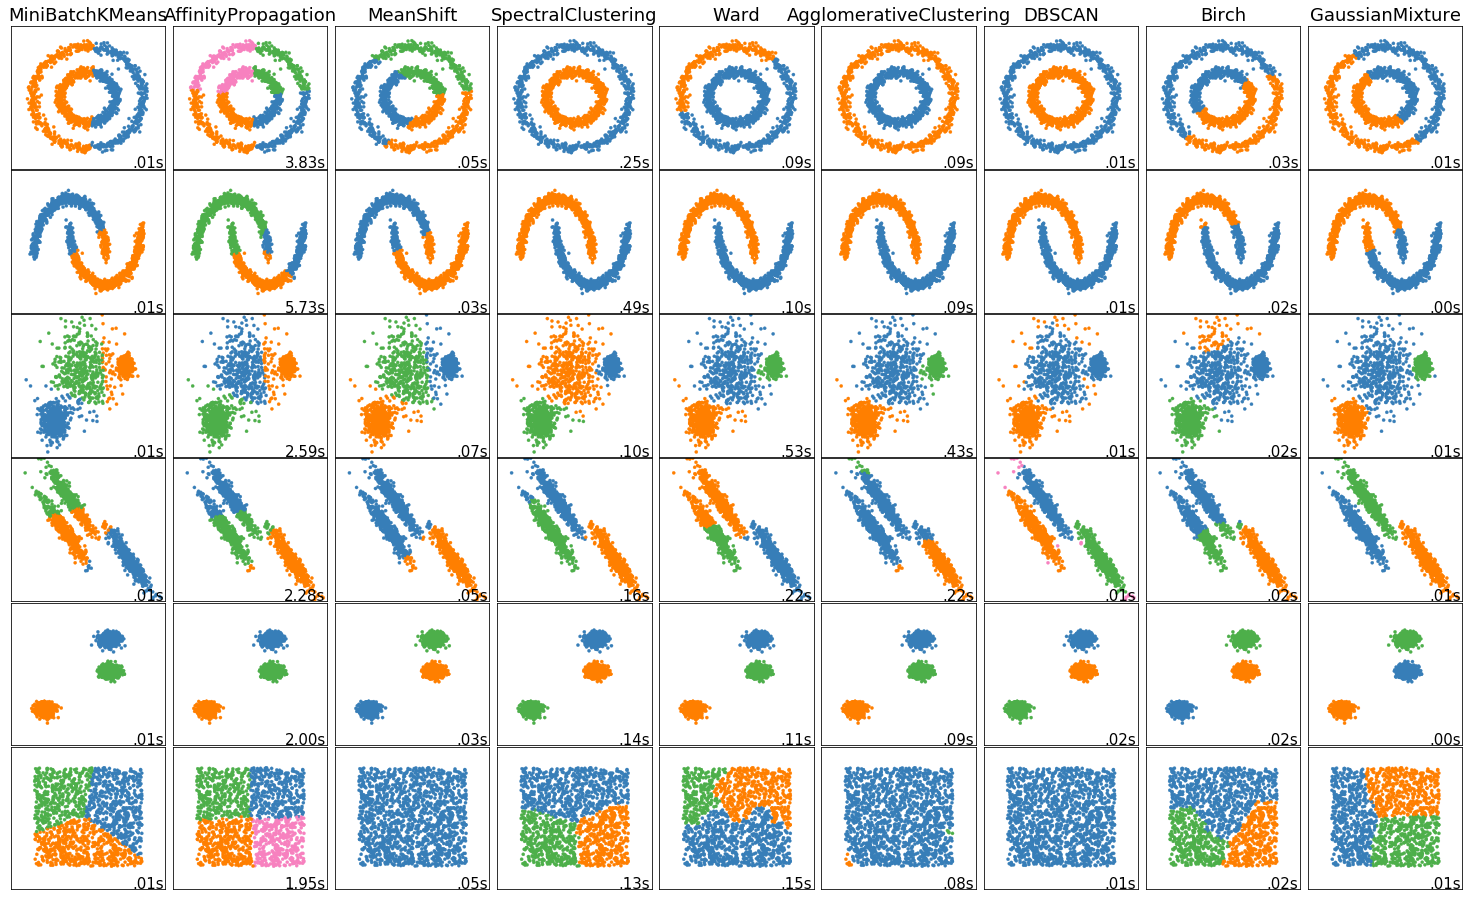

In [6]:

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()